## Stock Prediction Project
The Multivariate Time Series Forecasting project leverages Python and PyTorch and other essential libraries for data analysis and deep learning. The lab covers key steps, including data loading from Yahoo Finance, exploratory data analysis, preprocessing, model training, and performance evaluation. By focusing on the NASDAQ stock market index, the tutorial demonstrates the application of advanced techniques in time series forecasting. Readers are taken through the process of building, training, and evaluating a model, with a practical example predicting the next day's stock price.







## Make a copy of this notebook! Editing directly will not be saved.

# Step #1 Load the Data

In [105]:
import math
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns
import torch
import yfinance as yf
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

In [106]:
# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2014-01-01'

# Getting NVIDIA quotes
stockname = 'NVIDIA'
symbol = 'NVDA'
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


# Step #2 Exploring the Data

In [107]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2014-01-02 00:00:00+00:00,0.373992,0.39650,0.3995,0.39300,0.39800,260092000
2014-01-03 00:00:00+00:00,0.369512,0.39175,0.3980,0.39050,0.39725,259332000
2014-01-06 00:00:00+00:00,0.374464,0.39700,0.4000,0.39200,0.39575,409492000
2014-01-07 00:00:00+00:00,0.380595,0.40350,0.4050,0.39825,0.40100,333288000
2014-01-08 00:00:00+00:00,0.385782,0.40900,0.4110,0.40350,0.40500,308192000


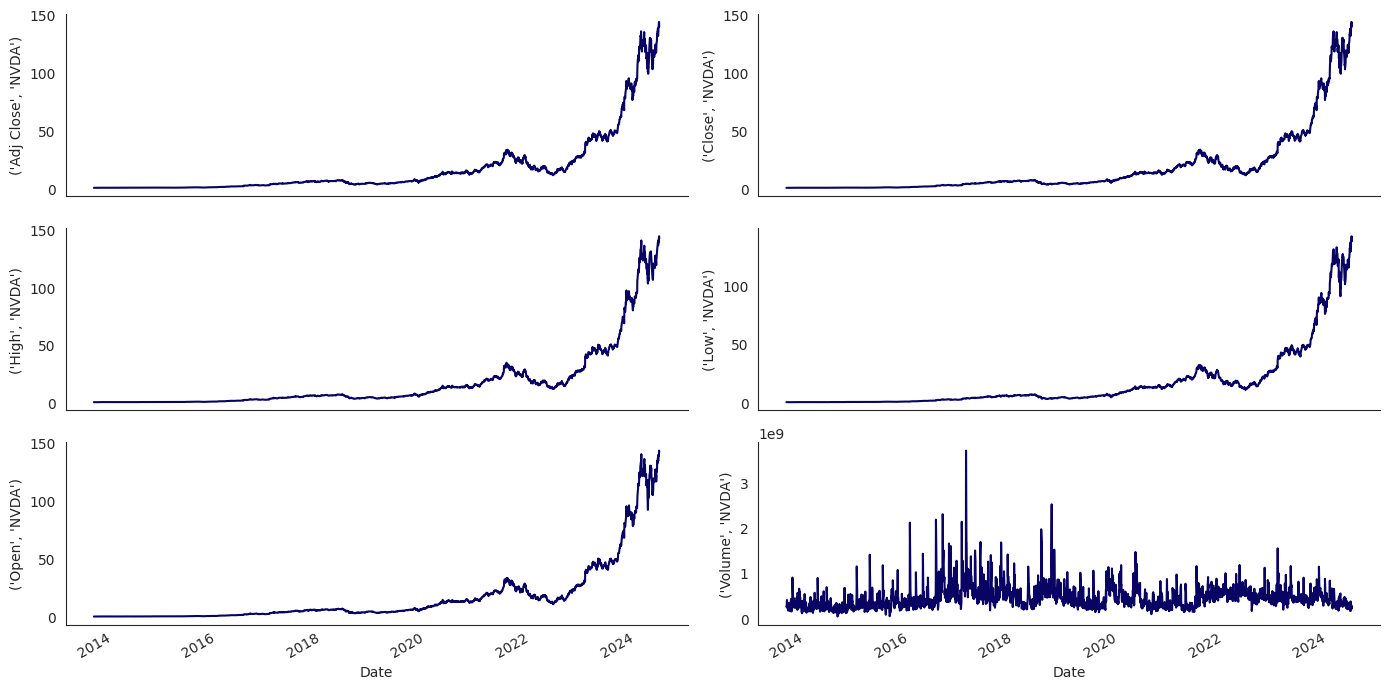

In [108]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [109]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

print('FEATURE LIST')
print([f for f in FEATURES])


FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


In [110]:
# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

Price,High,Low,Open,Close,Volume,Prediction
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,
Date,,,,,,
2024-10-17 00:00:00+00:00,140.889999,136.869995,139.339996,136.929993,306435900,136.929993
2024-10-18 00:00:00+00:00,138.899994,137.279999,138.669998,138.000000,176090200,138.000000
2024-10-21 00:00:00+00:00,143.710007,138.000000,138.130005,143.710007,264554500,143.710007
2024-10-22 00:00:00+00:00,144.419998,141.779999,142.910004,143.589996,226311600,143.589996
2024-10-23 00:00:00+00:00,142.429993,137.460007,142.029999,139.559998,284973100,139.559998


In [111]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2721, 5)


In [112]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2127, 50, 5) (2127, 1)
(544, 50, 5) (544, 1)
[0.00043848]
[0.00043848]


# Step #4 Model Training

In [113]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import math

In [114]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 5)
        self.fc2 = nn.Linear(5, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [115]:
# Preprocessing steps (assuming data_filtered, and the train and test splits are done)
scaler = MinMaxScaler()
np_data_unscaled = np.array(data_filtered)
np_data_scaled = scaler.fit_transform(np_data_unscaled)

x_train, y_train = partition_dataset(sequence_length, train_data)  # Assuming partition_dataset is defined
x_test, y_test = partition_dataset(sequence_length, test_data)

n_neurons = x_train.shape[1] * x_train.shape[2]
input_size = x_train.shape[2]
hidden_size = n_neurons // 2
num_layers = 2
output_size = 1
learning_rate = 1e-4

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [116]:
# Convert to Torch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 15

for epoch in range(epochs):
    for x_batch, y_batch in train_dataloader:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Get the predicted values
y_pred_scaled = model(x_test)
y_pred_scaled_numpy = y_pred_scaled.detach().numpy()

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled_numpy)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [1/15], Loss: 0.0261
Epoch [2/15], Loss: 0.0384
Epoch [3/15], Loss: 0.0365
Epoch [4/15], Loss: 0.0129
Epoch [5/15], Loss: 0.0152
Epoch [6/15], Loss: 0.0185
Epoch [7/15], Loss: 0.0081
Epoch [8/15], Loss: 0.0044
Epoch [9/15], Loss: 0.0128
Epoch [10/15], Loss: 0.0048
Epoch [11/15], Loss: 0.0131
Epoch [12/15], Loss: 0.0097
Epoch [13/15], Loss: 0.0112
Epoch [14/15], Loss: 0.0112
Epoch [15/15], Loss: 0.0108


# Step #5 Evaluate Model Performance

In [117]:
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 16.39
Mean Absolute Percentage Error (MAPE): 21.39 %
Median Absolute Percentage Error (MDAPE): 18.96 %


Index(['NVDA', 'residuals', 'y_train', 'y_pred', 'y_test'], dtype='object', name='Ticker')


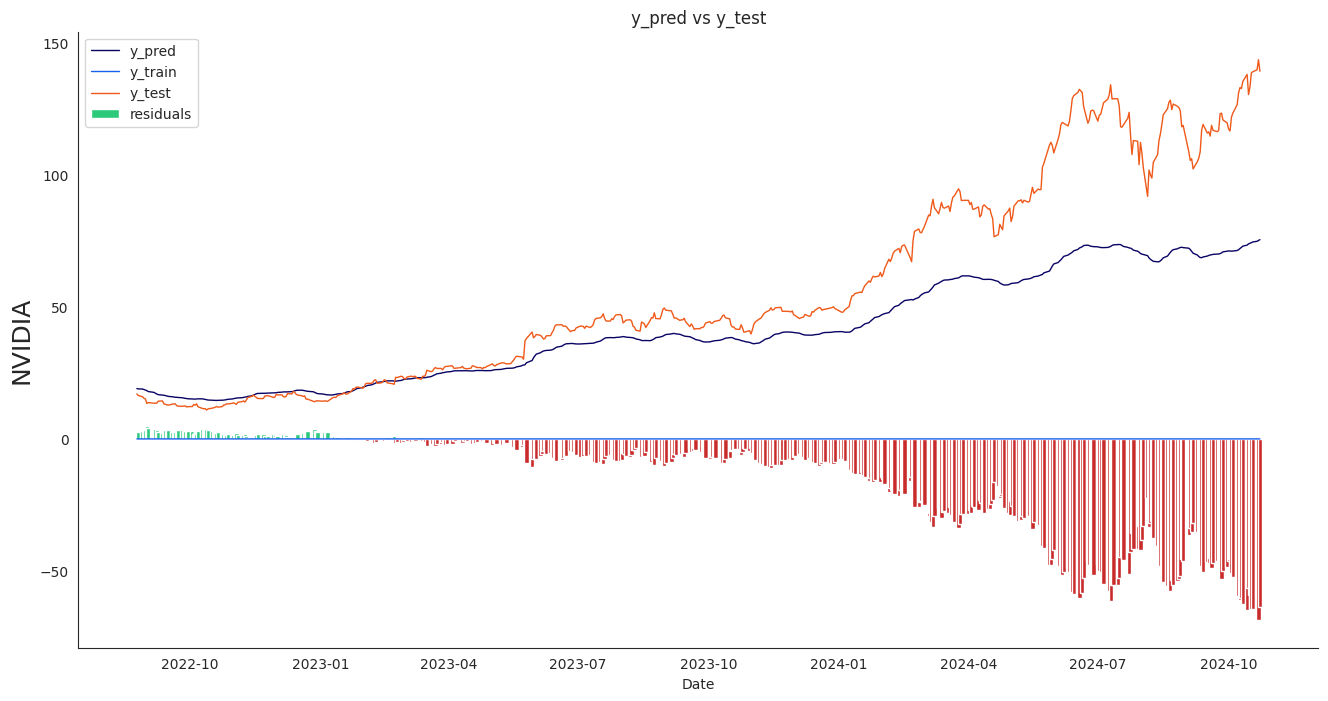

In [118]:
# The date from which on the date is displayed
display_start_date = "2019-01-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
y_test_length = y_test.shape[0]  # This will give you the number of rows in y_test
valid.insert(1, "y_train", y_train[:y_test_length], True)
valid["y_test"] = y_test_unscaled[:len(valid)]
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])
print(valid.columns)

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

# Step #6 Predict Next Day's Price

In [119]:
df_temp = df[-sequence_length:]
new_df = df_temp.drop(df_temp.columns[0], axis=1)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test_new = torch.from_numpy(np.array(X_test_new)).float()

# Make predictions using the model
pred_price_scaled = model(X_test_new)
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.detach().numpy().reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'].values[-1], 2)  # Get the last value in the "Close" column
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

The close price for NVIDIA at 2024-10-24 was [139.56]
The predicted close price is 75.72000122070312 ([-84.31]%)
